In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Preparation – Unzipping Training Data

This step copies the `train_new.zip` archive from your **Google Drive** into the **local runtime environment** of Google Colab. Then, it extracts (unzips) the contents into a new directory called `/content/train_unzipped`.

> Google Colab uses temporary local storage, so files from Google Drive need to be copied locally before they can be accessed or modified.

**Steps performed:**
1. **Copy** the zip file from Google Drive (Example):  
   `"/content/drive/MyDrive/vit_training/train_new.zip"` → `"/content/train_new.zip"`
2. **Unzip** the dataset to:  
   `"/content/train_unzipped"`



In [ ]:
# Copy the zip file to Colab's local storage
!cp "/content/drive/MyDrive/vit_training/train_new.zip" "/content/train_new.zip"

# Unzip it locally
!unzip -q "/content/train_new.zip" -d "/content/train_unzipped"

# Training and Fine-Tuning:


## Importing All Required Libraries

This block imports all the necessary libraries and modules used throughout the notebook for:

### **General Utilities**
- `os` – Interacting with the file system (e.g., file paths).
- `torch` – Core PyTorch library for deep learning.
- `numpy` – Numerical operations and array handling.


### **Model Explainability**
- `shap` – SHAP (SHapley Additive exPlanations) library for model explainability and visualisation of feature importance.


### **Image Processing**
- `tifffile` – To read `.tif` image files (common in microscopy datasets).
- `PIL` – Python Imaging Library (via `Image`, `ImageEnhance`) for image manipulation.
- `matplotlib.pyplot` – Plotting library used for visualisations and charts.


### **Evaluation Metrics**
- `accuracy_score` – From `sklearn.metrics`, used to calculate classification accuracy.

### **Dataset Handling & Transforms**
- `torchvision.datasets`, `torchvision.transforms` – For loading and transforming image datasets.


### **Hugging Face Transformers**
Used for model loading, training, and processing image inputs:
- `ViTForImageClassification` – Vision Transformer model for image classification tasks.
- `ViTImageProcessor`, `AutoImageProcessor` – Preprocessing tools to convert raw images into model-ready tensors.
- `Trainer`, `TrainingArguments` – High-level API for training and evaluating models.
- `EarlyStoppingCallback` – To stop training early if performance plateaus.
- `DefaultDataCollator` – Handles batching and padding of image data for training.



In [ ]:
# All required imports
import os
import torch
import numpy as np
import shap
import tifffile
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
from transformers import (
    ViTForImageClassification,
    ViTImageProcessor,
    AutoImageProcessor,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DefaultDataCollator
)


## **Model Fine Tuning, on the BPS Data**






### Here's What This Code Does

This section of the notebook is where everything comes together — you're about to **fine-tune a Vision Transformer (ViT)** model using your own image dataset.

The idea is simple: we take a powerful pretrained model (`google/vit-base-patch16-224-in21k` by default), and we retrain it just a bit so it learns to classify your specific images — like distinguishing between different types of cell damage, for example.

---

### How it works:

1. **Configuration**:
   First, we define some important settings — things like:
   - Which model we want to use
   - Where our training and validation images are stored
   - How many epochs to train for
   - Learning rate, image size, batch size, etc.

   These settings are all defined up top as variables, so it’s easy to tweak them without diving into the code.

2. **Preprocessing**:
   Before we feed images to the model, we:
   - Convert them to RGB just in case they’re greyscale
   - Resize them all to 224x224 pixels (which is what ViT expects)
   - Apply normalisation using the pretrained model’s settings
   - Optionally augment training images (e.g., horizontal flips, random rotation)

3. **Dataset loading**:
   Your dataset should be structured like this:
- `train_unzipped/`  
  ├── `train/` (contains training images)  
  │   ├── `class_1/`  
  │   └── `class_2/`  
  └── `val/` (contains validation images)  
     ├── `class_1/`  
     └── `class_2/`  


  The code loads these using PyTorch’s `ImageFolder`, applies the transforms, and wraps them to make them compatible with Hugging Face's `Trainer`.

4. **Model setup**:
The pretrained ViT model is loaded and updated to have the right number of output labels (matching your classes). It's ready to learn from your data.

5. **Training setup**:
We use Hugging Face’s `Trainer` API, which takes care of:
- Training loop
- Evaluation after each epoch
- Logging
- Checkpointing (so you don’t lose progress)
- Early stopping if the model stops improving

6. **Training**:
If you’ve trained before and checkpoints exist, the code will pick up where you left off (as long as `USE_CHECKPOINT = True`). Otherwise, it starts from scratch.

7. **Saving the model**:
After training, the final model is saved locally. Then, for extra safety, it’s copied to your Google Drive.

---

### Before you run this block, make sure:

- Your dataset is already unzipped and organised into `train/` and `val/` folders inside `/content/train_unzipped`
- You’ve mounted Google Drive using:

```python
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# Global Config — change these values to reuse with different models or datasets

MODEL_NAME = "google/vit-base-patch16-224-in21k"  # ViT variant or other HuggingFace model
TRAIN_DIR = "/content/train_unzipped/train/train"  # Path to your training images
VAL_DIR = "/content/train_unzipped/train/val"      # Path to your validation images
OUTPUT_DIR = "/content/drive/MyDrive/vit_training/vit-checkpoint2"  # Checkpoint save path
FINAL_MODEL_PATH = "/content/vit-checkpoint-final2"                # Final model save path
NUM_EPOCHS = 1
LEARNING_RATE = 5e-5
BATCH_SIZE = 32
IMAGE_SIZE = 224
USE_CHECKPOINT = True

# Utility Functions
def to_rgb(img):
    return img.convert("RGB")

class HFDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return {"pixel_values": image, "labels": label}

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Dataset and Preprocessing
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

train_transform = transforms.Compose([
    transforms.Lambda(to_rgb),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

val_transform = transforms.Compose([
    transforms.Lambda(to_rgb),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

train_dataset_raw = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
val_dataset_raw = datasets.ImageFolder(root=VAL_DIR, transform=val_transform)

class_names = train_dataset_raw.classes
num_labels = len(class_names)

train_dataset = HFDataset(train_dataset_raw)
val_dataset = HFDataset(val_dataset_raw)

# Model and Trainer
model = ViTForImageClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    logging_dir="./logs",
    logging_steps=10,
    dataloader_num_workers=2,
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DefaultDataCollator(),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train and Save
# Determining resume strategy
if USE_CHECKPOINT and os.path.isdir(OUTPUT_DIR) and any("checkpoint" in f for f in os.listdir(OUTPUT_DIR)):
    print("Checkpoint found. Resuming training...")
    trainer.train(resume_from_checkpoint=True)
else:
    print("No checkpoint found or resume disabled. Starting fresh training...")
    trainer.train()
trainer.save_model(FINAL_MODEL_PATH)

# Optional: copy model to Drive
!cp -r {FINAL_MODEL_PATH} /content/drive/MyDrive/vit_training/vit-checkpoint-final2


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


No checkpoint found or resume disabled. Starting fresh training...


cp: cannot copy a directory, '/content/drive/MyDrive/vit_training/vit-checkpoint2', into itself, '/content/drive/MyDrive/vit_training/vit-checkpoint2/vit-checkpoint2'


### Testing the Final Vision Transformer Model

In this section, we’re evaluating the model we previously trained — to see how well it performs on completely unseen data (the test set). This is important because it gives us a final, unbiased estimate of how well the model generalises.

We start by setting a few global parameters. These include the model name and the location where the trained model is stored (usually on Google Drive), the path to the test dataset, image size, batch size, and where to store the test results.

Next, we define a small utility class called `HFDataset`. This just wraps our image dataset in a way that Hugging Face's `Trainer` can work with. We also define a function called `compute_metrics` that calculates accuracy, that’s the main metric we’ll be reporting.

We then load two things:  
- The **trained model** from the path you saved it to earlier  
- The **image processor** that goes with the model, this ensures the test images are normalised in the same way the model expects

After that, we apply the same image transformations that were used during validation: convert to RGB, resize to 224x224, turn into a tensor, and normalise. The test dataset is loaded using `ImageFolder`, so make sure your test folder is structured by class, just like your training and validation folders.

Then we configure the evaluation settings using Hugging Face’s `TrainingArguments`, but this time with training turned off (`do_train=False`) and evaluation turned on (`do_eval=True`). We don’t want to update the model anymore, we’re only checking how well it performs.

Finally, we pass everything into a `Trainer` instance, run `.evaluate()`, and print the final test accuracy.

---

To recap, this block:

- Loads your final trained model  
- Prepares and transforms your test dataset  
- Evaluates the model using Hugging Face’s tools  
- Prints the test accuracy so you can see how well your model performs on new, unseen data

Make sure your test images are correctly placed under the `test/` folder and grouped into subfolders by class — just like your training and validation images were.


In [ ]:
# Global Config — change these as needed
MODEL_NAME = "google/vit-base-patch16-224-in21k"   # Name used for the processor
MODEL_PATH = "/content/drive/MyDrive/vit_training/vit-checkpoint-final2"  # Path to saved model
TEST_DIR = "/content/train_unzipped/train/test"    # Path to test dataset
IMAGE_SIZE = 224
BATCH_SIZE = 16
OUTPUT_DIR = "./test-results"

# Utilities
class HFDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return {"pixel_values": image, "labels": label}

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Load model and processor
model = ViTForImageClassification.from_pretrained(MODEL_PATH)
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

# Define test transforms
test_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# Load test dataset
test_dataset_raw = datasets.ImageFolder(root=TEST_DIR, transform=test_transform)
test_dataset = HFDataset(test_dataset_raw)

# Define Trainer args
test_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_eval_batch_size=BATCH_SIZE,
    do_train=False,
    do_eval=True,
    report_to="none"
)

# Run evaluation
trainer = Trainer(
    model=model,
    args=test_args,
    compute_metrics=compute_metrics
)

results = trainer.evaluate(test_dataset)
print("Final Test Accuracy:", results.get("eval_accuracy", "N/A"))


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Final Test Accuracy: 0.8143190258226098




# **HeatMaps and Visualisation**

##Visualise a Raw .tif Image with False Colour

This block loads a 16-bit grayscale `.tif` image, normalises its pixel values to the range `[0, 1]`, and displays it using a perceptual colormap (like `'viridis'`) to enhance visual contrast. This helps you better see structure in microscopy images that are otherwise difficult to interpret visually.


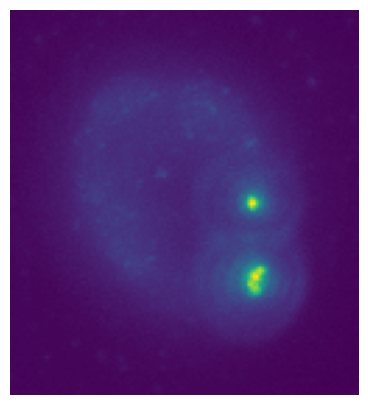

In [ ]:
# Load 16-bit grayscale .tif image
img_path = "/content/train_unzipped/train/test/Fe/P242_73665006707-A6_001_014_proj.tif"
img = tifffile.imread(img_path)  # shape: (H, W), dtype: uint16

# Normalize pixel intensities to [0, 1]
img_norm = (img - np.min(img)) / (np.max(img) - np.min(img))

# Plot with colormap to make it look like your example
plt.figure(figsize=(5, 5))
plt.imshow(img_norm, cmap="viridis")  # or 'plasma', 'inferno', etc.
plt.axis("off")
plt.show()

## Visualising ViT Attention with Rollout – One Image at a Time

This section of the notebook lets you peek inside the Vision Transformer’s head to understand how it "sees" the image during classification. Using an approach called **attention rollout**, we can create a heatmap showing which parts of the image influenced the model's decision the most.

---

### What’s Actually Happening Here?

We start by setting a few important global variables:

- The path to your **trained ViT model** (on Google Drive)
- The **test image** you want to visualise
- Some display settings like image size, brightness, and whether to show a zoomed-in attention region

Then, the code does the following:

1. **Loads the test image** (in `.tif` format) and converts it to RGB using a custom function called `tif_loader`. This also applies normalisation and a false colour mapping (via the `viridis` colormap) for better visual contrast.

2. **Runs the model in inference mode** and extracts the attention matrices from all layers. These attention matrices tell us how the ViT model distributes its "focus" across image patches.

3. **Computes joint attention**:  
   A function called `compute_joint_attention` combines all the attention heads across all layers into a single attention map that gives a global view of what the model is focusing on.

4. **Overlays the attention heatmap** on top of the original image using `get_attention_overlay`. It rescales and enhances the image for better visibility and blends in the heatmap with it.

5. **Displays results side-by-side**:
   - The original image
   - The image with the attention heatmap overlay
   - Optionally, a **zoomed-in version** of the region the model focused on most

6. **Prints the predicted class name** on top of the visualisation — this helps you link the model's decision to the area it used to make that decision.

---

### Why This Is Useful

This visualisation gives you interpretability. Instead of just seeing a prediction (e.g., "Fe-damaged cell"), you can now **see which region of the cell image the model based that prediction on**. This is especially useful for:
- Spot-checking whether the model is making decisions for the right reasons
- Building trust in model performance
- Debugging poor predictions

---

### Before You Run This Block:

- Make sure the `TEST_IMAGE_PATH` is set to a valid `.tif` image inside your test dataset.
- Your model should have been saved with `output_attentions=True`, as we’re accessing internal attention weights.
- Your test images should be stored in class folders inside `/content/train_unzipped/train/test/`, just like during training and validation.

If anything goes wrong, the script will let you know — including if it can’t find the image.

---

Once run, you’ll see a heatmap visualisation showing where the model focused its attention, and what class it predicted. It’s a great way to understand what your ViT model is actually doing under the hood.


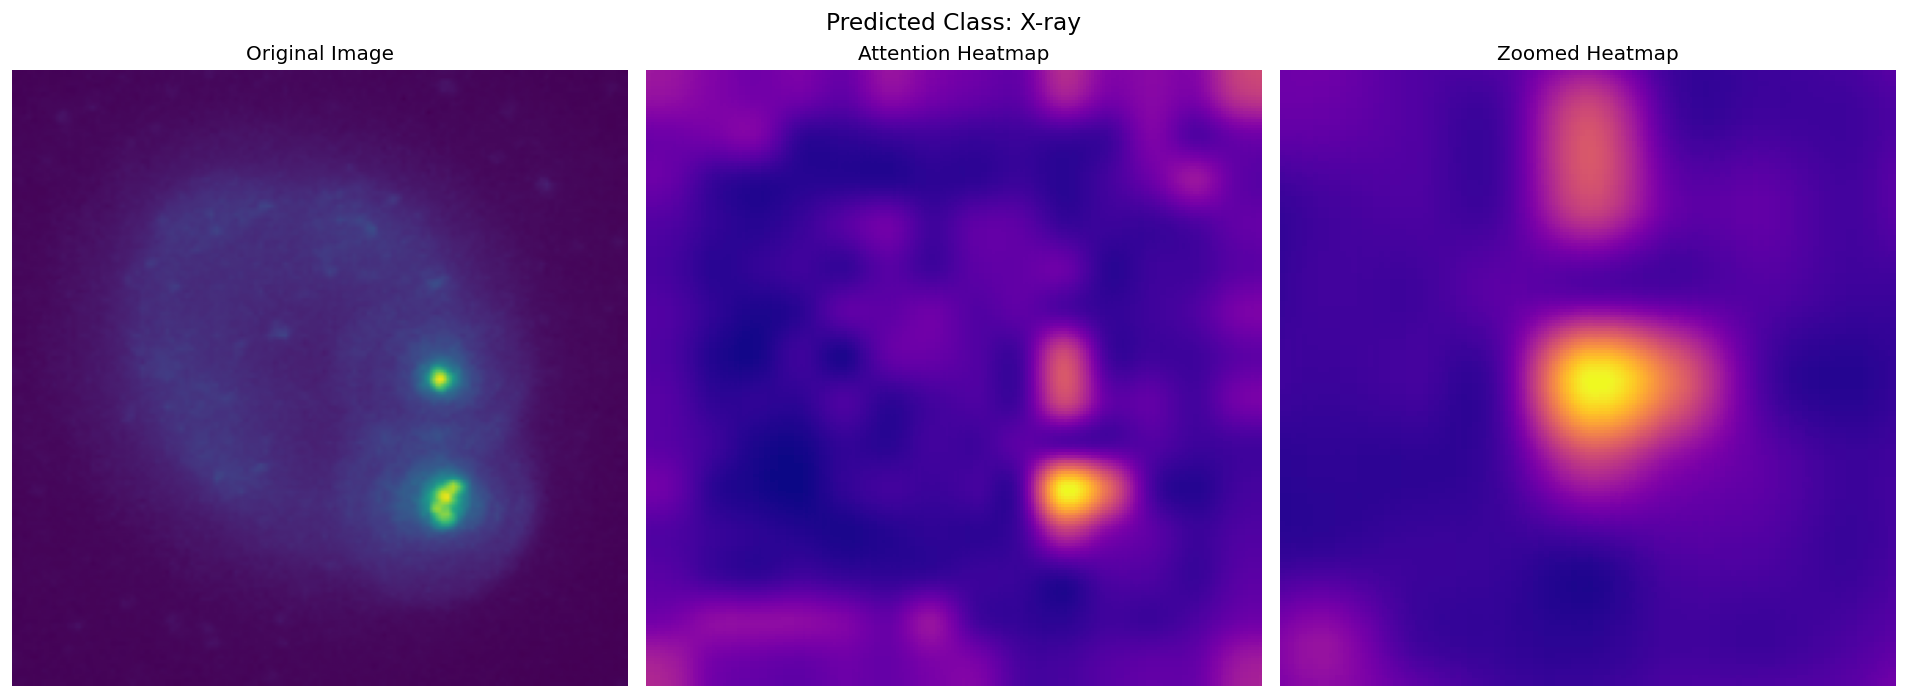

In [ ]:

# ========================================================
# GLOBAL VARIABLES — USER SHOULD ONLY EDIT THESE
# ========================================================
MODEL_PATH = "/content/drive/MyDrive/vit_training/vit-checkpoint-final"
MODEL_NAME = "google/vit-base-patch16-224-in21k"
TEST_IMAGE_PATH = "/content/train_unzipped/train/test/Fe/P242_73665006707-A6_001_014_proj.tif"
TEST_DATASET_DIR = "/content/train_unzipped/train/test"
IMAGE_SIZE = 224
BRIGHTNESS = 1.0
CONTRAST = 1.0
SHOW_ZOOM = True
# ========================================================

# Helper: Load .tif image and convert to RGB
def tif_loader(path):
    img = tifffile.imread(path)
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    colormap = plt.get_cmap("viridis")
    img_coloured = colormap(img / 255.0)[..., :3]
    img_coloured = (img_coloured * 255).astype(np.uint8)
    return Image.fromarray(img_coloured)

# Attention rollout function
def compute_joint_attention(attentions):
    att_mat = torch.stack(attentions).squeeze(1).mean(dim=1)
    residual_att = torch.eye(att_mat.size(-1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1, keepdim=True)
    joint_attn = aug_att_mat[0]
    for i in range(1, aug_att_mat.size(0)):
        joint_attn = aug_att_mat[i] @ joint_attn
    return joint_attn

# Overlay attention mask
def get_attention_overlay(img_tensor, attention_map, processor):
    image = img_tensor.numpy().transpose(1, 2, 0)
    image = (image * np.array(processor.image_std)) + np.array(processor.image_mean)
    image = np.clip(image, 0, 1)
    pil_image = Image.fromarray((image * 255).astype(np.uint8))
    pil_image = ImageEnhance.Brightness(pil_image).enhance(BRIGHTNESS)
    pil_image = ImageEnhance.Contrast(pil_image).enhance(CONTRAST)
    image = np.array(pil_image) / 255.0
    mask = attention_map[0, 1:].reshape(14, 14).detach().cpu().numpy()
    mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-6)
    mask = Image.fromarray(np.uint8(mask * 255)).resize((IMAGE_SIZE, IMAGE_SIZE), resample=Image.BICUBIC)
    mask = np.array(mask) / 255
    return image, mask

# Show attention heatmap (with optional zoom)
def show_side_by_side(original, heatmap, title=""):
    fig, axs = plt.subplots(1, 3 if SHOW_ZOOM else 2, figsize=(16, 6), dpi=120)
    axs[0].imshow(original)
    axs[0].set_title("Original Image")
    axs[0].axis("off")
    axs[1].imshow(original)
    axs[1].imshow(heatmap, cmap="plasma", alpha=1.0, interpolation='none', vmin=0, vmax=1)
    axs[1].set_title("Attention Heatmap")
    axs[1].axis("off")
    if SHOW_ZOOM:
        peak_y, peak_x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
        half = 112 // 2
        x0, x1 = max(0, peak_x - half), min(heatmap.shape[1], peak_x + half)
        y0, y1 = max(0, peak_y - half), min(heatmap.shape[0], peak_y + half)
        zoom_orig = original[y0:y1, x0:x1]
        zoom_heat = heatmap[y0:y1, x0:x1]
        zoom_orig = np.array(Image.fromarray((zoom_orig * 255).astype(np.uint8)).resize((224, 224)))
        zoom_heat = np.array(Image.fromarray((zoom_heat * 255).astype(np.uint8)).resize((224, 224)))
        axs[2].imshow(zoom_orig / 255.0, interpolation='none')
        axs[2].imshow(zoom_heat / 255.0, cmap="plasma", alpha=1.0, interpolation='none', vmin=0, vmax=1)
        axs[2].set_title("Zoomed Heatmap")
        axs[2].axis("off")
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Load model and processor
model = ViTForImageClassification.from_pretrained(MODEL_PATH, output_attentions=True)
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
model.eval()

# Load class names from test dataset
test_dataset_raw = datasets.ImageFolder(root=TEST_DATASET_DIR, loader=tif_loader)
class_names = test_dataset_raw.classes

# Inference and visualisation for one image
try:
    pil_img = tif_loader(TEST_IMAGE_PATH)
    inputs = processor(images=pil_img, return_tensors="pt")
    test_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
    ])
    img_tensor = test_transform(pil_img)

    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions
        logits = outputs.logits
        pred_label = logits.argmax(dim=1).item()

    joint_attn = compute_joint_attention(attentions)
    img, mask = get_attention_overlay(img_tensor, joint_attn, processor)
    show_side_by_side(img, mask, title=f"Predicted Class: {class_names[pred_label]}")

except Exception as e:
    print(f"Error: {e}")
    print("Please ensure the 'TEST_IMAGE_PATH' is correct and the file exists.")


##Batch Attention Visualisation – Correct vs Incorrect Predictions

This section builds on the previous single-image attention visualisation and extends it to multiple test images. The goal here is to show how the model attends to different regions of various images, depending on whether it got the prediction right or wrong.

---

### What’s Different From the Previous Section?

- **Batch Processing**:
  Instead of visualising just one image, this block automatically loops through the test dataset and collects:
  - 3 correctly classified samples
  - 3 incorrectly classified samples


Each sample includes:
- The original image
- The attention heatmap overlay
- A zoomed-in version of the most activated region

Titles clearly label the predicted vs true class for easy interpretation.

---

### Why This Is Useful

This block helps you:
- Quickly get a sense of *where the model is making mistakes
- Compare visual patterns between correct and incorrect predictions
- Visually inspect if the attention maps make sense or reveal biases

---

> **Before running**: Make sureyour model is trained with `output_attentions=True`.



✅ Correctly Classified (Any Class):


/tmp/ipython-input-414504753.py:131: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


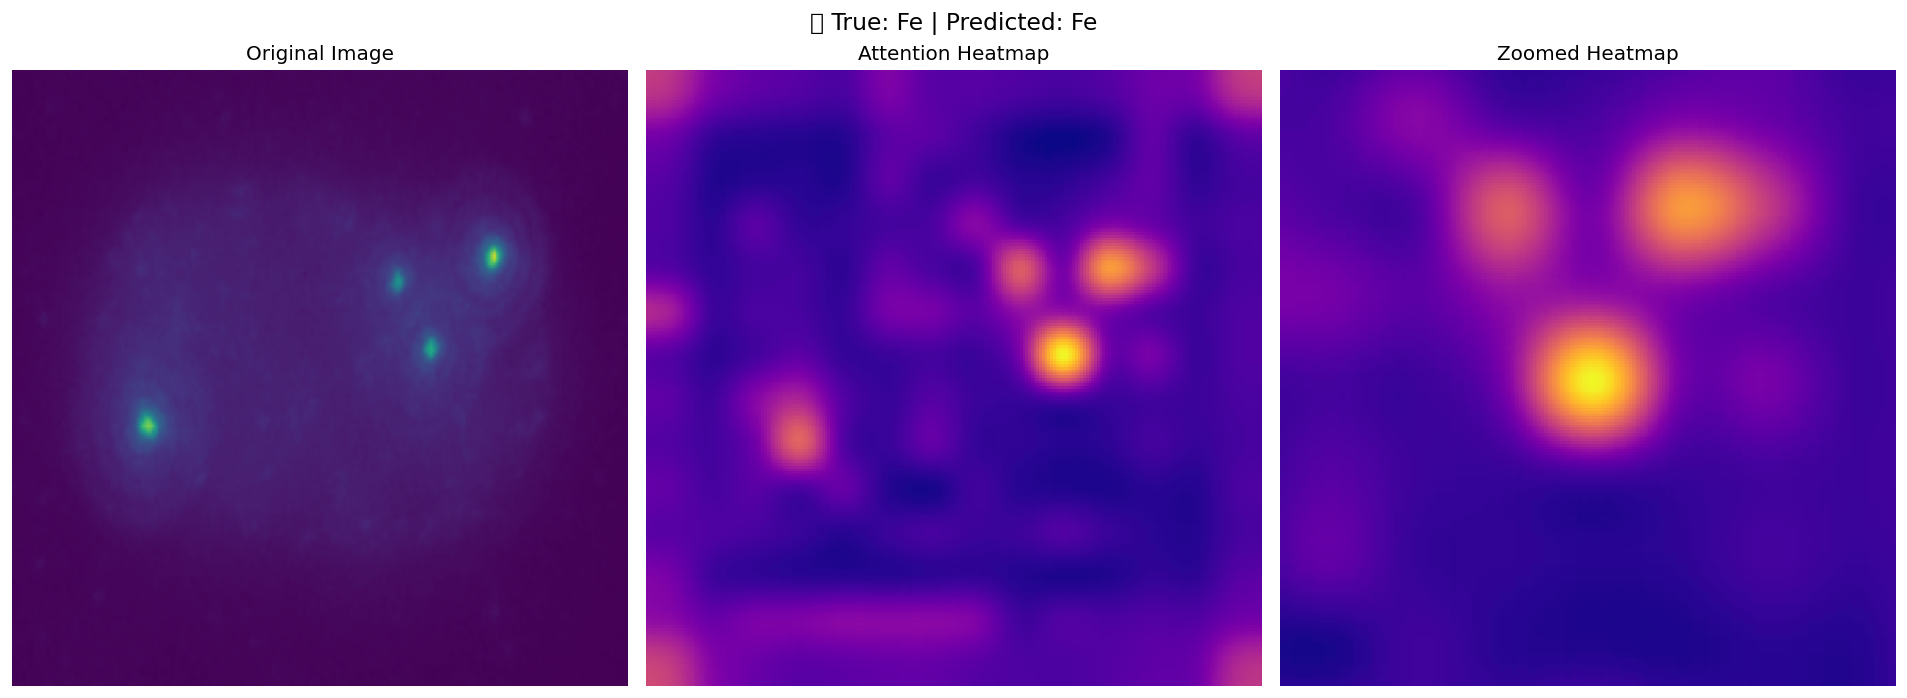

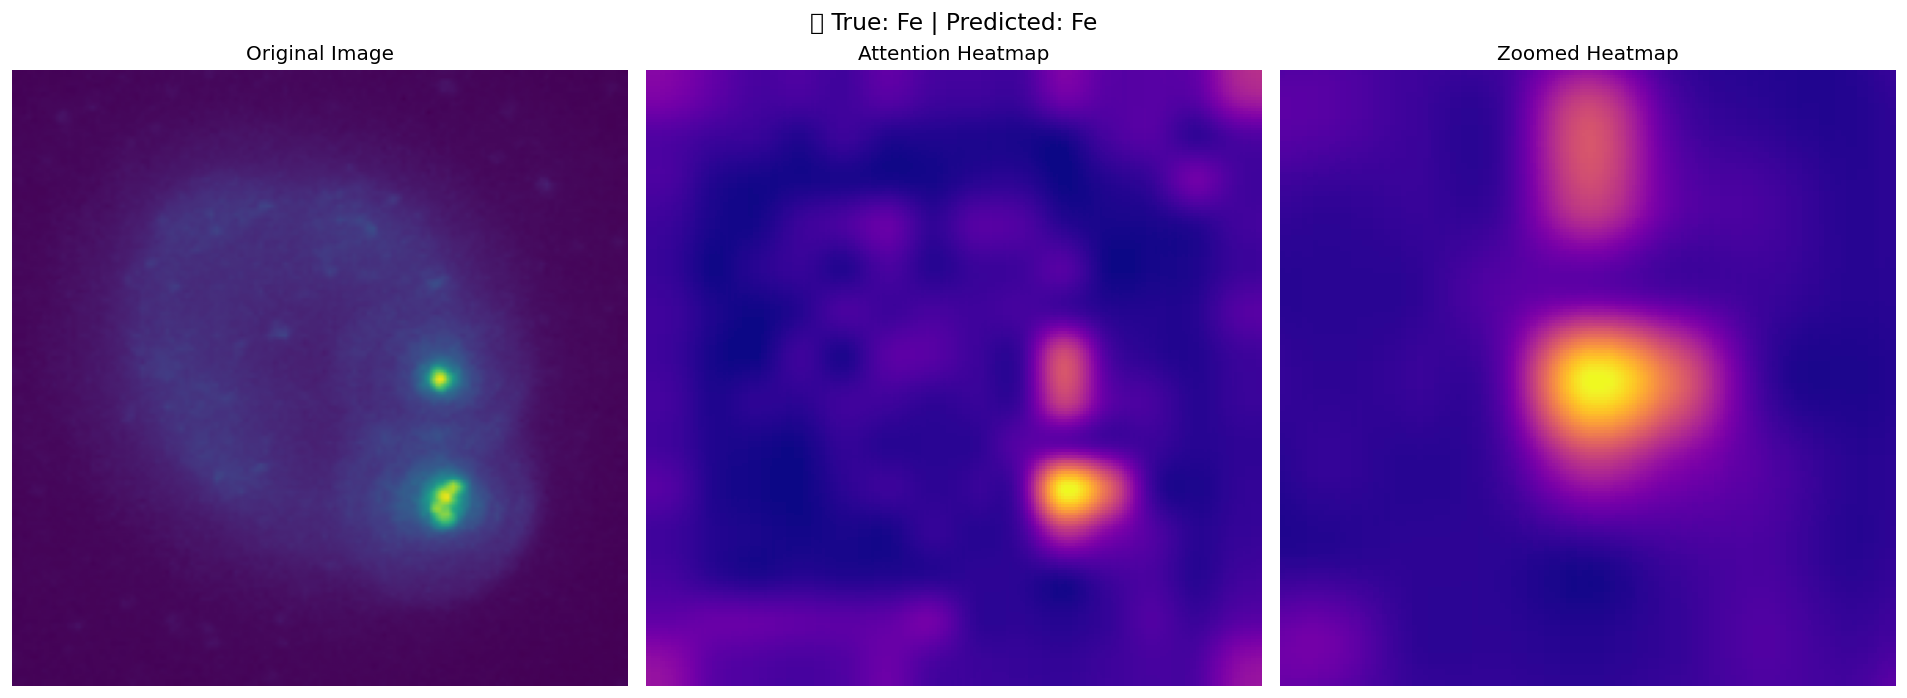

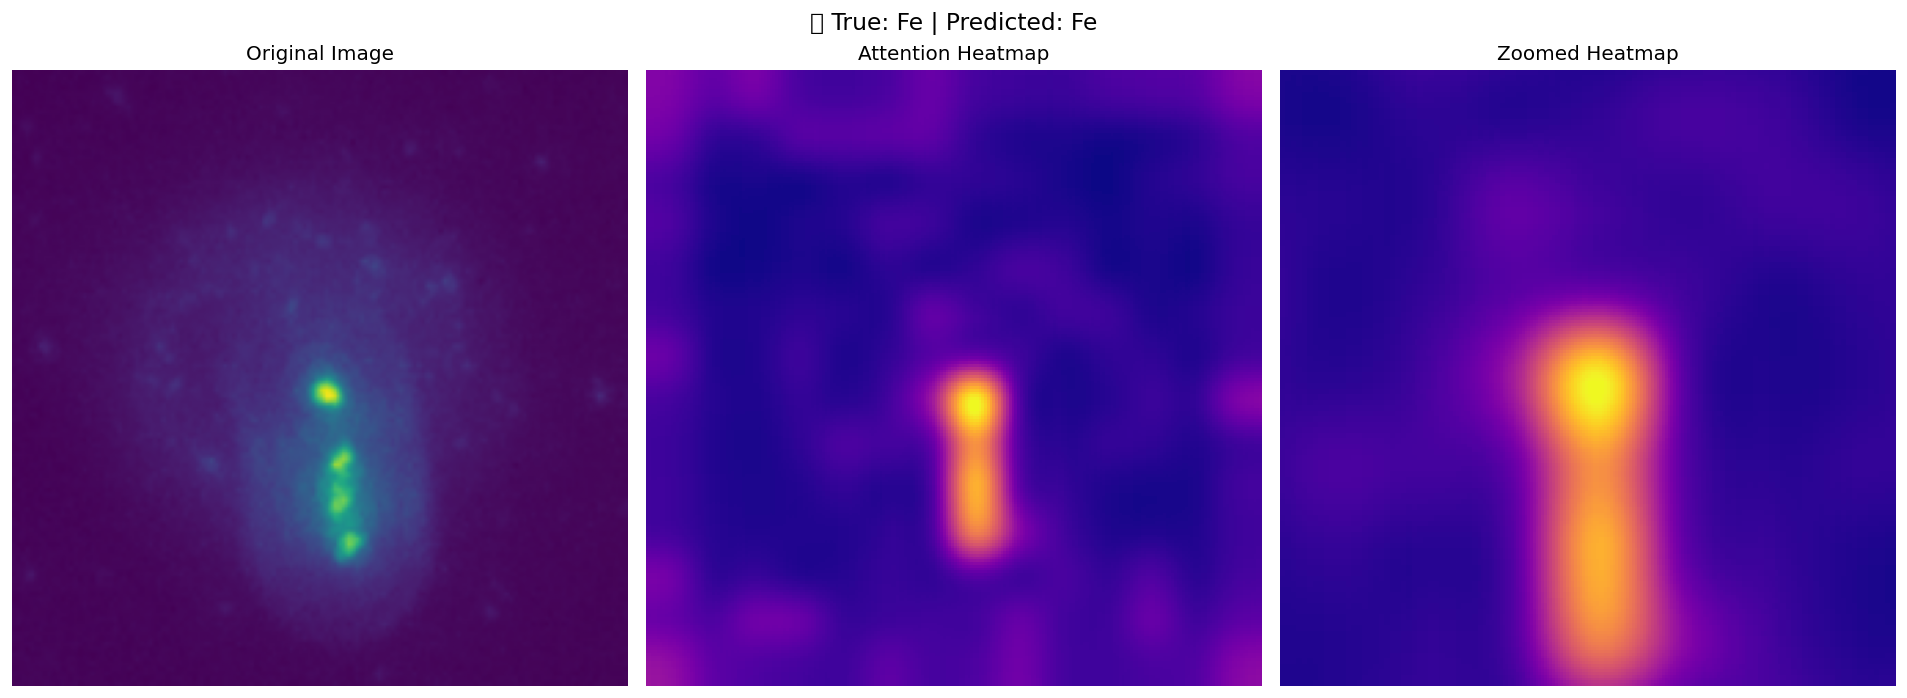


❌ Incorrectly Classified (Any Class):


/tmp/ipython-input-414504753.py:131: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


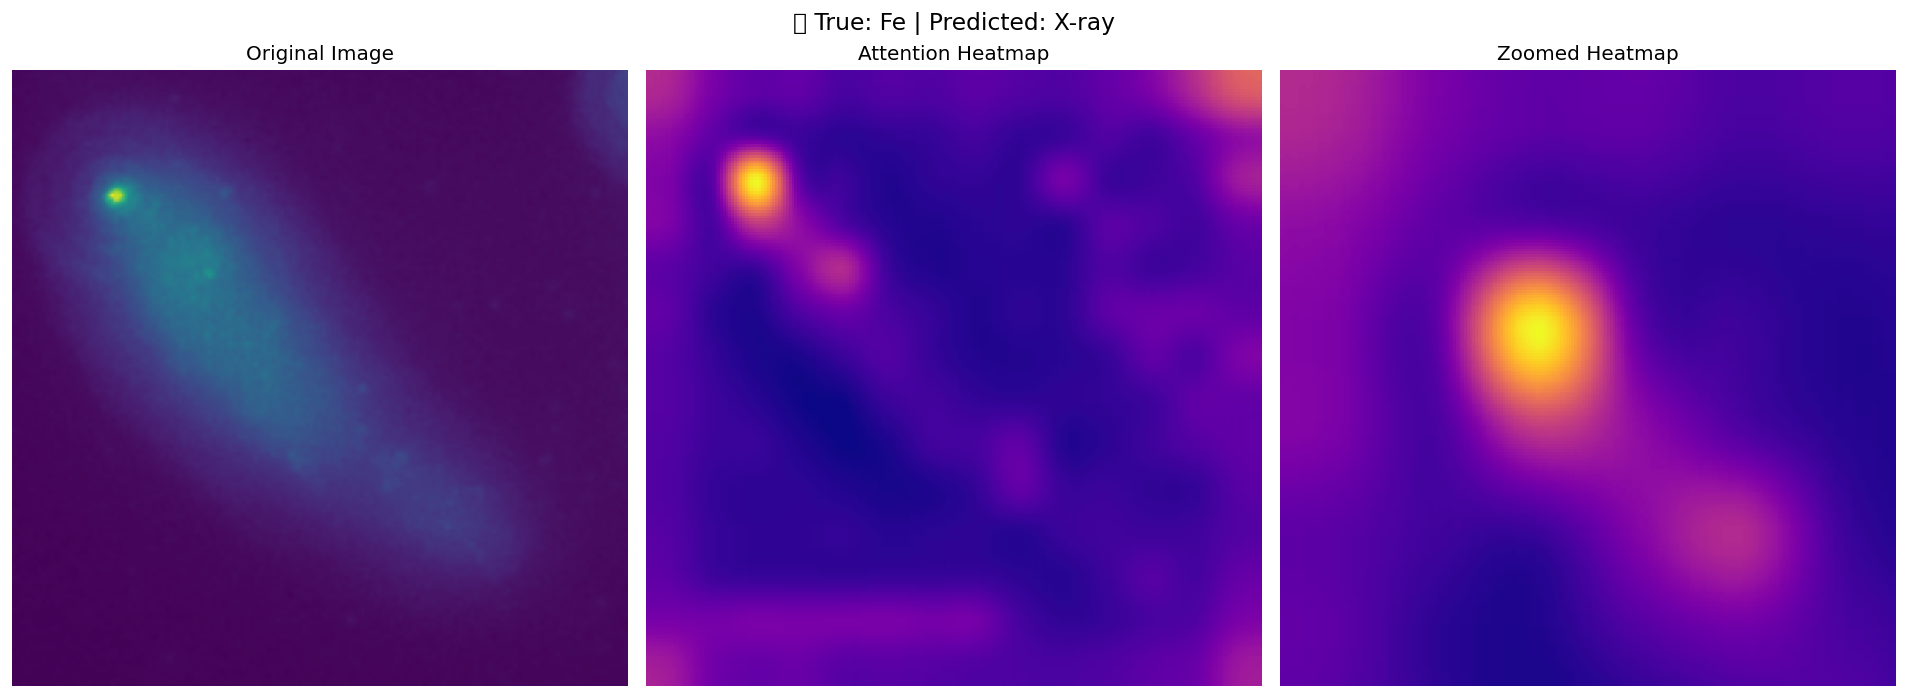

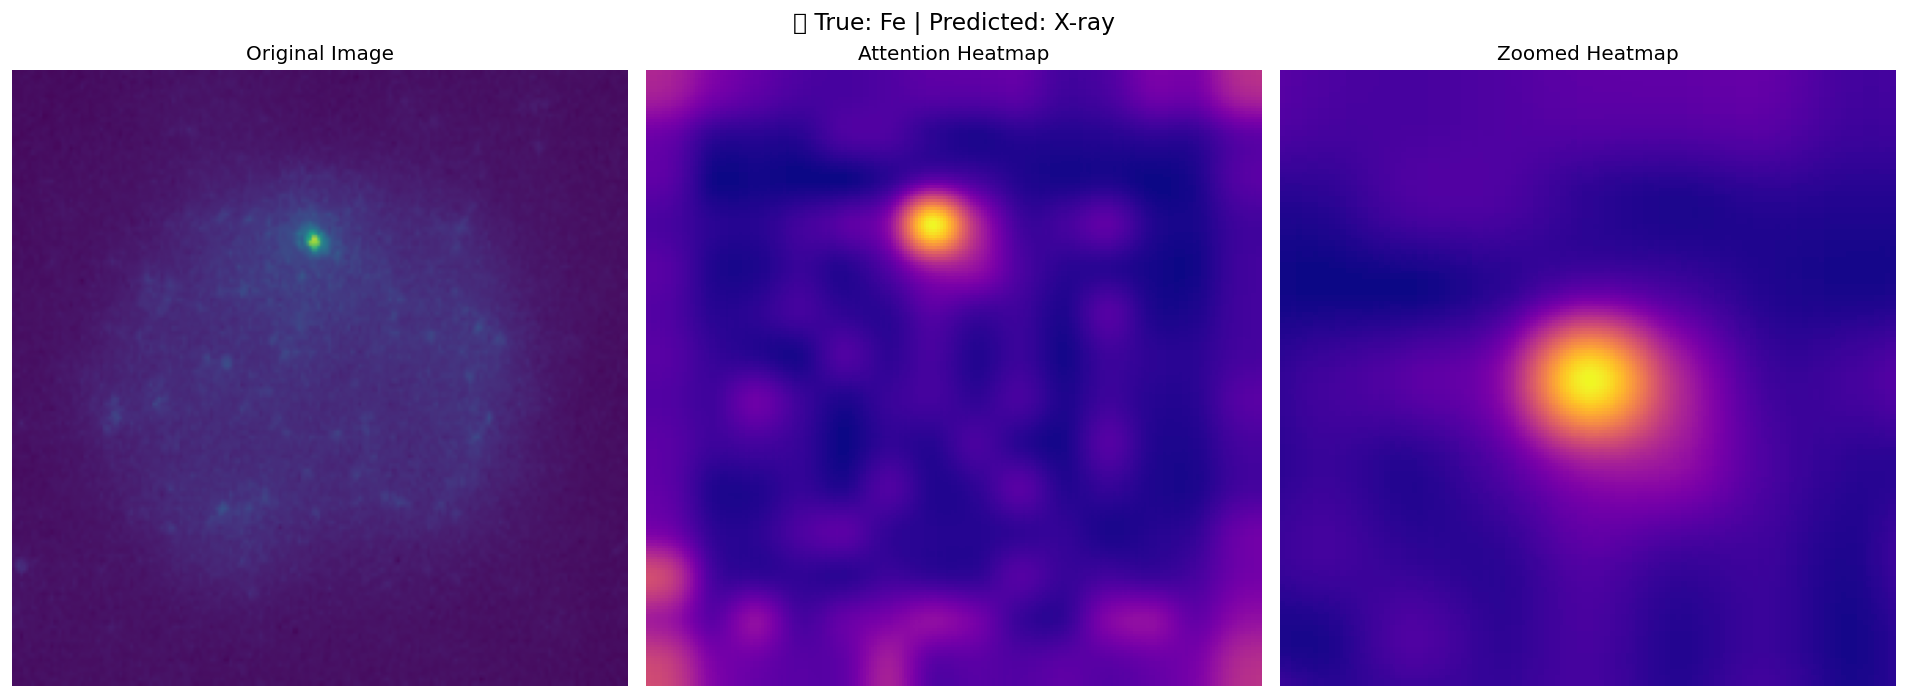

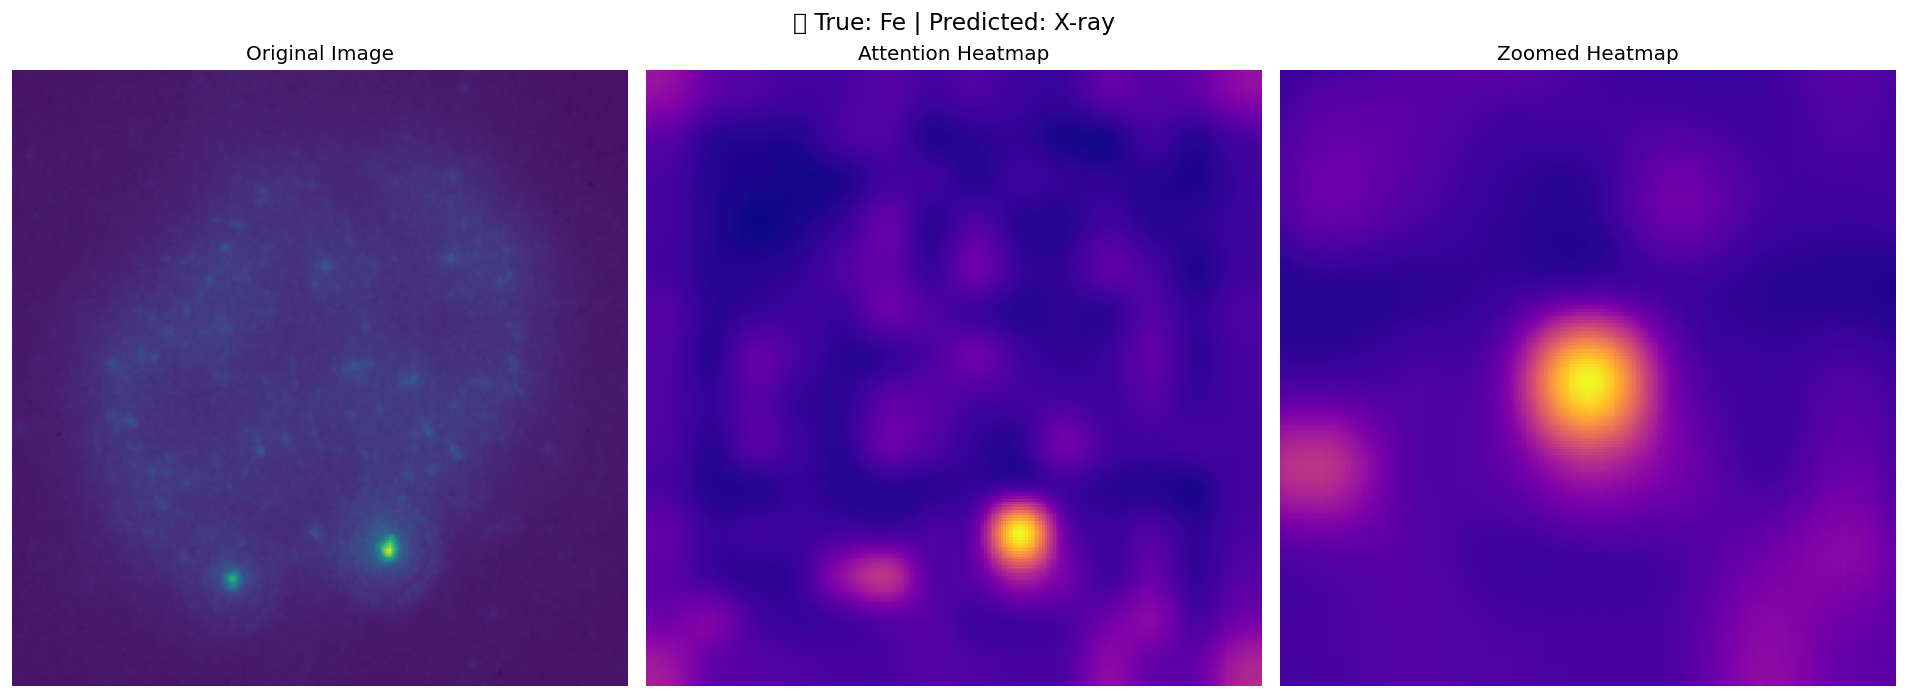


🧪 ✅ X-ray Correct:


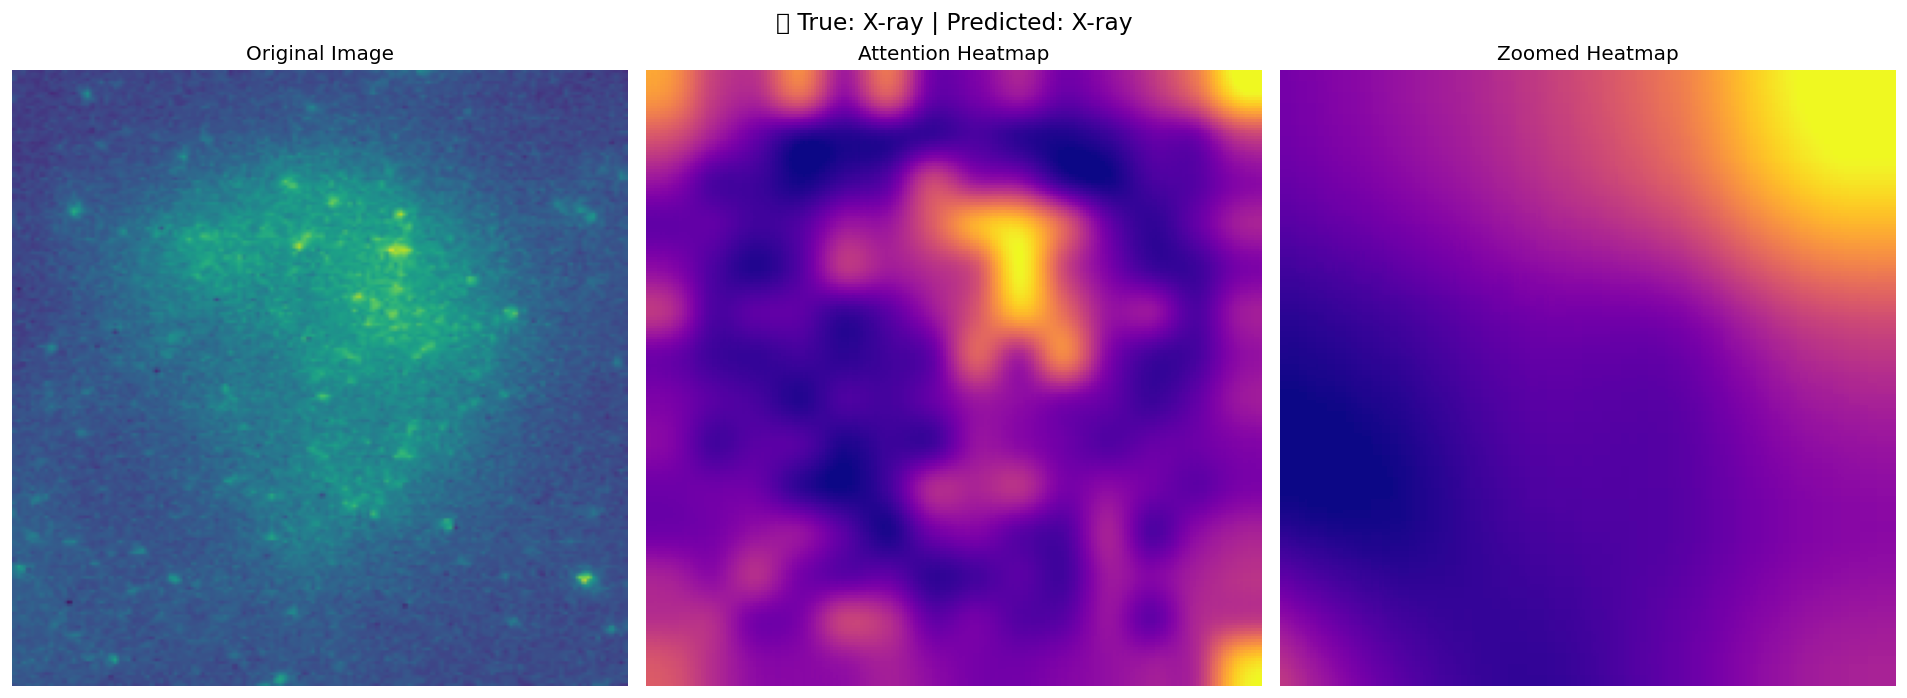

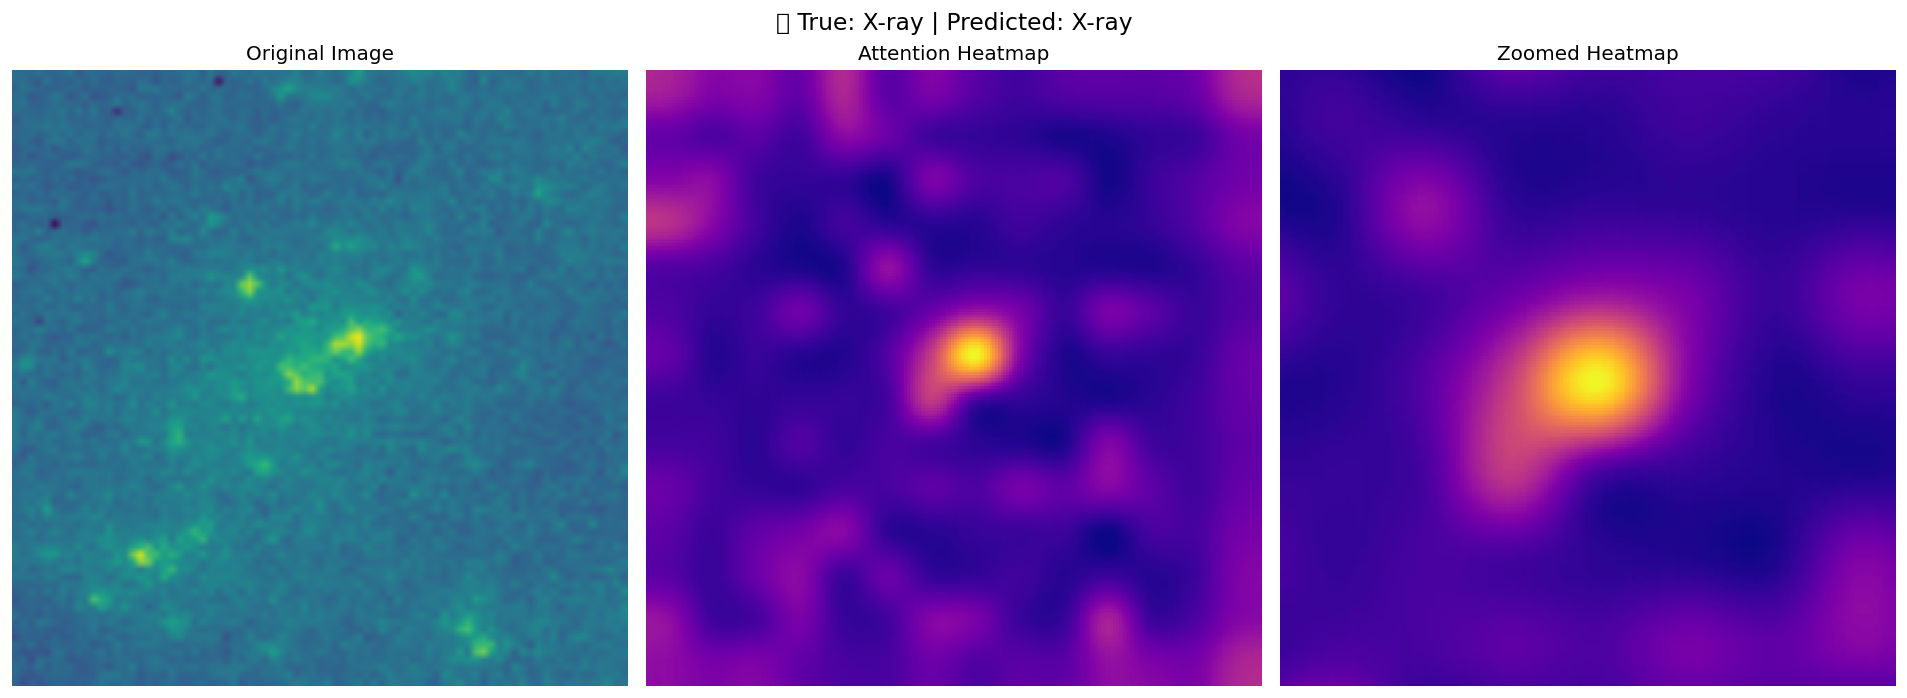

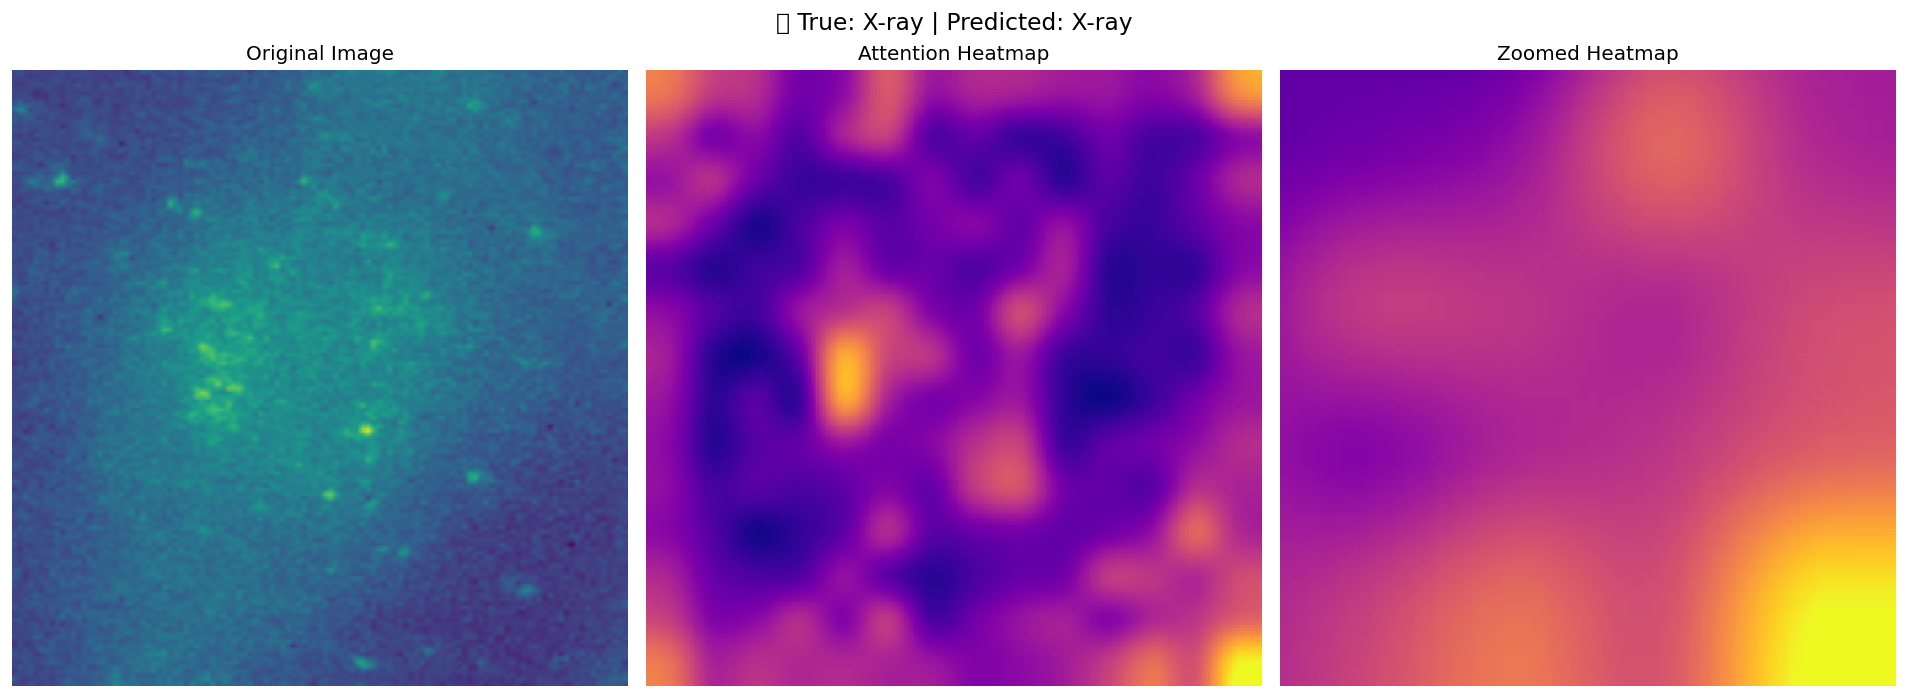


🧪 ❌ X-ray Incorrect:


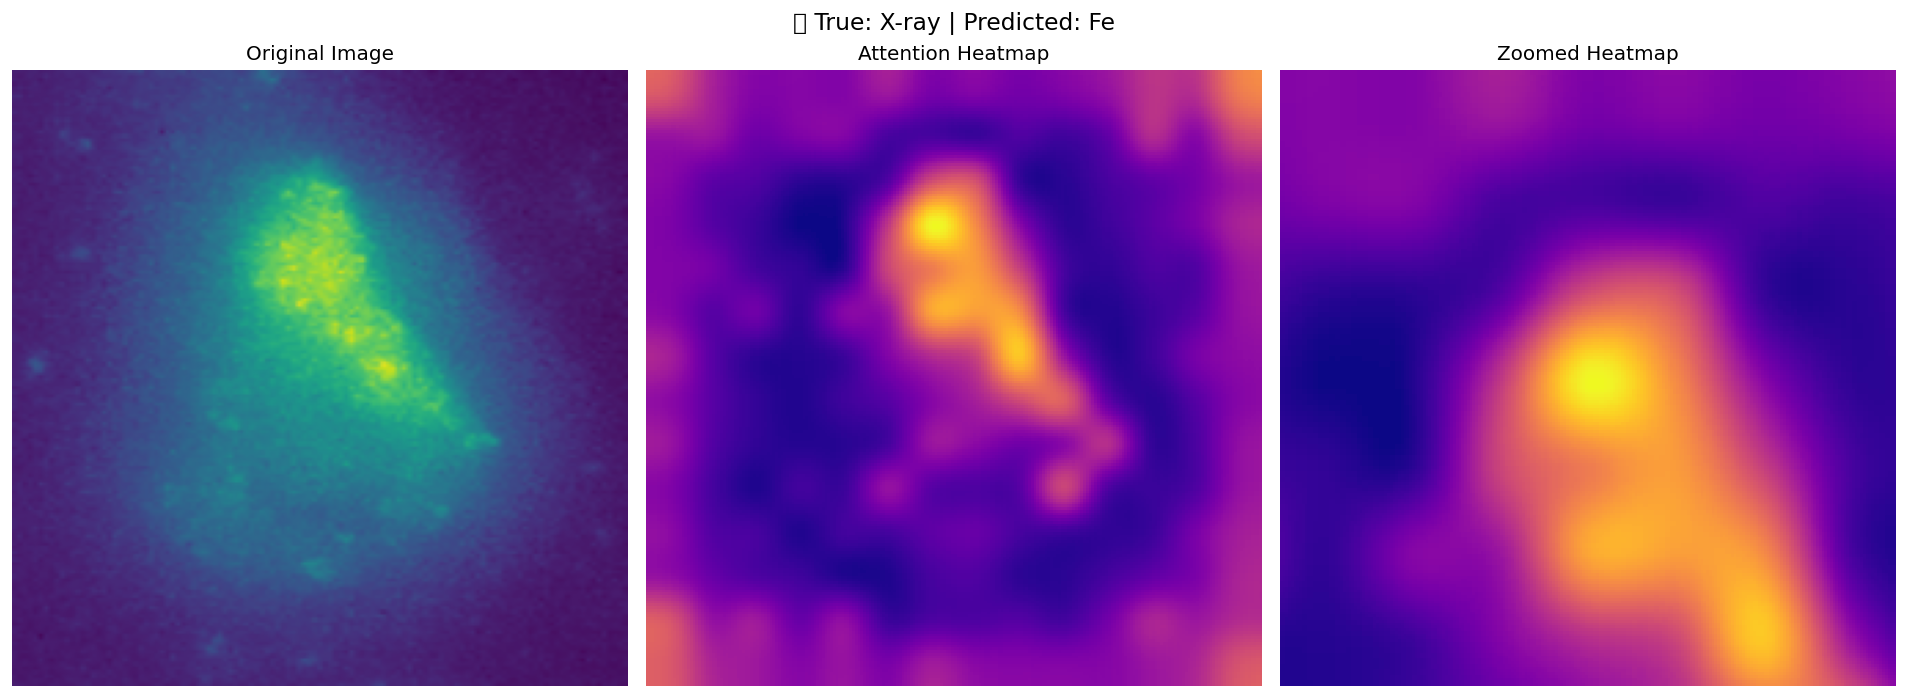

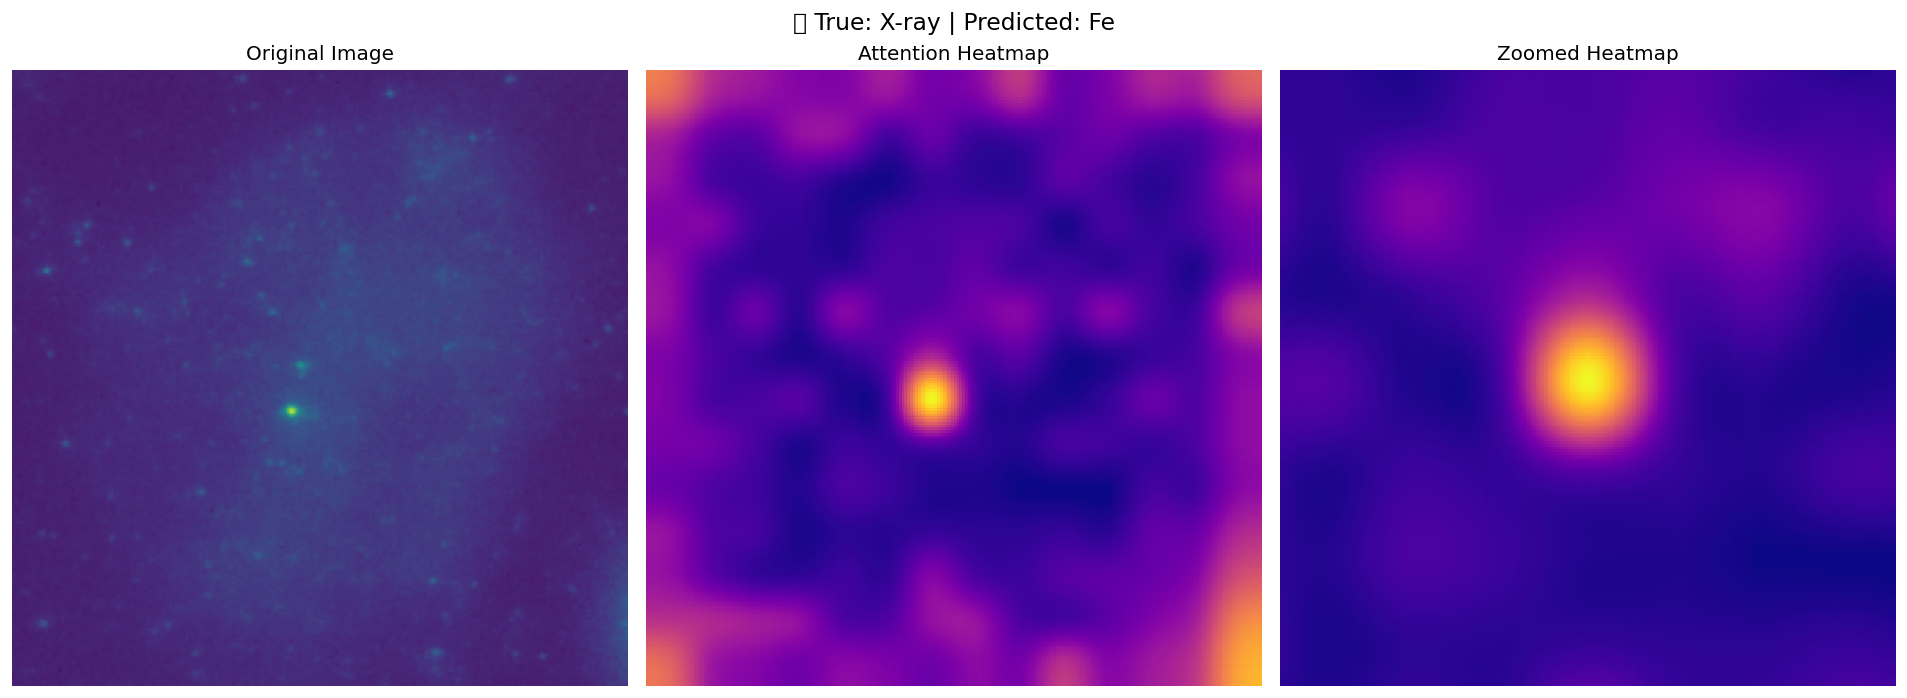

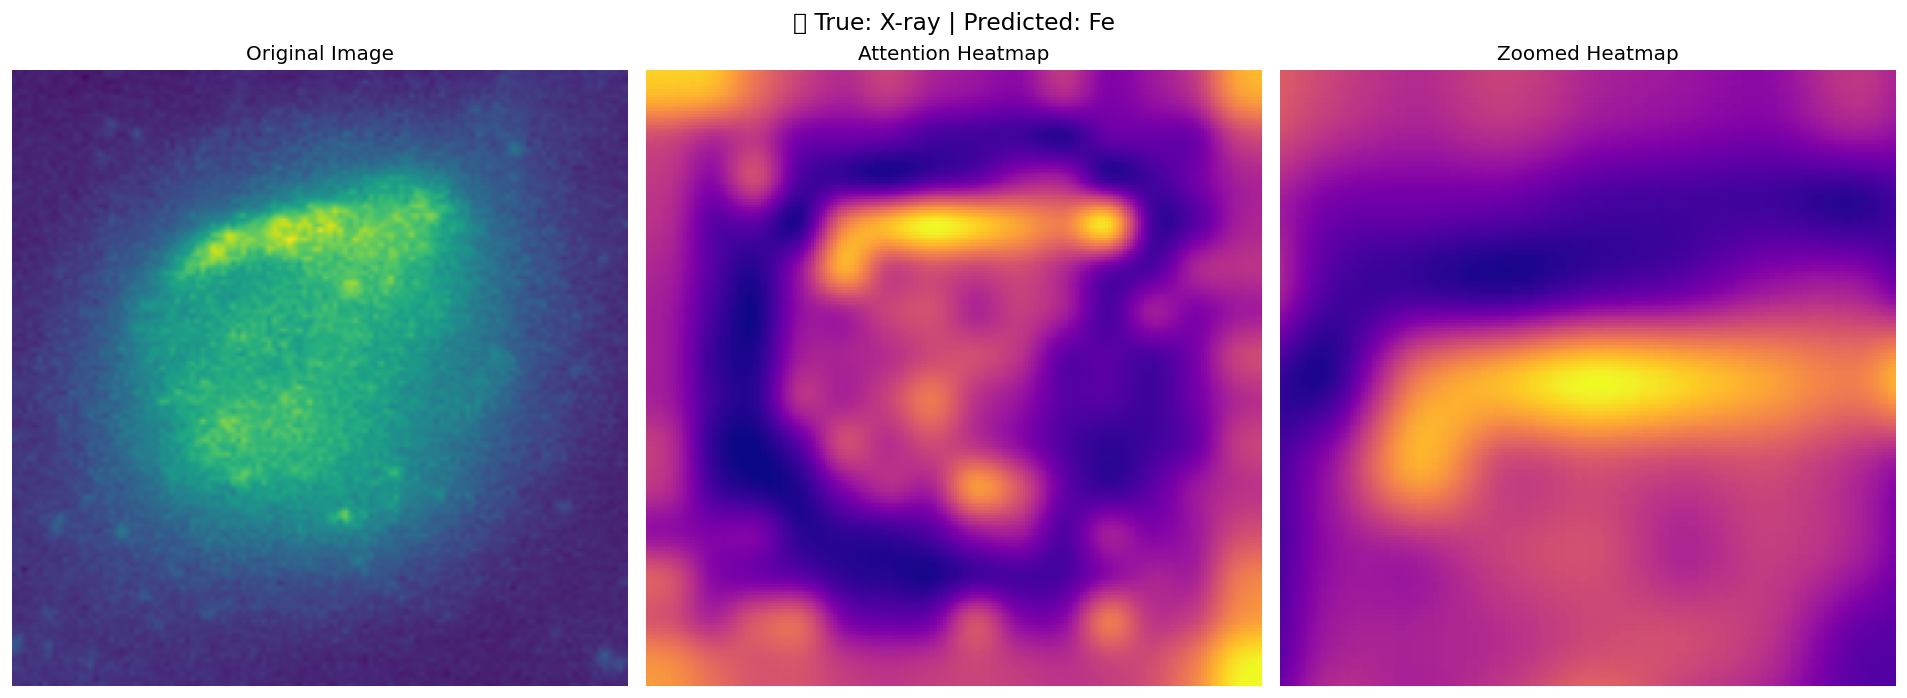

In [ ]:
# Specify Model Path, Test_Dir, and Processor

MODEL_PATH = "/content/drive/MyDrive/vit_training/vit-checkpoint-final2"
TEST_DIR = "/content/train_unzipped/train/test"
MODEL = ViTForImageClassification.from_pretrained(MODEL_PATH, output_attentions=True)
PROCESSOR = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# ========================================================
# GLOBAL CONTROL VARIABLES — edit here
# ========================================================
ORIGINAL_BRIGHTNESS = 1
ORIGINAL_CONTRAST = 1

HEATMAP_ALPHA = 1.0
HEATMAP_CMAP = 'plasma'
HEATMAP_VMIN = 0
HEATMAP_VMAX = 1
HEATMAP_RESIZE_TO = (224, 224)
HEATMAP_RESIZE_METHOD = 'lanczos'   # Options: 'nearest', 'bilinear', 'bicubic', 'lanczos'
HEATMAP_GAMMA = 0.5                 # Gamma < 1.0 boosts bright regions
HEATMAP_BLUR = True                 # Apply optional Gaussian blur

ZOOM_ENABLED = True
ZOOM_SIZE = 112
ZOOM_INTERPOLATION = 'bicubic'  # 'nearest', 'bilinear', 'bicubic'
ZOOM_CMAP = HEATMAP_CMAP
ZOOM_ALPHA = HEATMAP_ALPHA
ZOOM_VMIN = HEATMAP_VMIN
ZOOM_VMAX = HEATMAP_VMAX
ZOOM_ORIG_INTERP = 'none'
ZOOM_MASK_INTERP = 'none'
# ========================================================

def tif_loader(path):
    import tifffile
    img = tifffile.imread(path)  # Load 16-bit .tif as grayscale
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)  # Normalise to [0, 1]

#Stretch contrast to enhance
    img = np.clip(img, 0, 1)  # Keep safe range
    img = (img * 255).astype(np.uint8)

    # Convert grayscale to RGB (viridis false color look)
    colormap = plt.get_cmap("viridis")  # you can use 'plasma', 'inferno', etc.
    img_coloured = colormap(img / 255.0)[..., :3]  # drop alpha
    img_coloured = (img_coloured * 255).astype(np.uint8)

    return Image.fromarray(img_coloured)



model.eval()

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])
test_dataset_raw = datasets.ImageFolder(root=TEST_DIR, transform=test_transform, loader=tif_loader)
class_names = test_dataset_raw.classes
image_paths = test_dataset_raw.samples

def compute_joint_attention(attentions):
    att_mat = torch.stack(attentions).squeeze(1)
    att_mat = att_mat.mean(dim=1)
    residual_att = torch.eye(att_mat.size(-1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1, keepdim=True)
    joint_attentions = aug_att_mat[0]
    for i in range(1, aug_att_mat.size(0)):
        joint_attentions = aug_att_mat[i] @ joint_attentions
    return joint_attentions

def get_attention_overlay(img_tensor, attention_map):
    image = img_tensor.clone().numpy().transpose(1, 2, 0)
    if image.shape[2] == 1:
        image = np.repeat(image, 3, axis=2)
    image = (image * np.array(processor.image_std)) + np.array(processor.image_mean)
    image = np.clip(image, 0, 1)
    pil_image = Image.fromarray((image * 255).astype(np.uint8))
    pil_image = ImageEnhance.Brightness(pil_image).enhance(ORIGINAL_BRIGHTNESS)
    pil_image = ImageEnhance.Contrast(pil_image).enhance(ORIGINAL_CONTRAST)
    image = np.array(pil_image) / 255.0
    mask = attention_map[0, 1:].reshape(14, 14).detach().cpu().numpy()
    mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-6)
    mask = Image.fromarray(np.uint8(mask * 255)).resize(HEATMAP_RESIZE_TO, resample=Image.BICUBIC)
    mask = np.array(mask) / 255
    return image, mask

def show_side_by_side(original, heatmap, title=""):
    fig, axs = plt.subplots(1, 3 if ZOOM_ENABLED else 2, figsize=(16, 6), dpi=120)
    axs[0].imshow(original)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(original)
    axs[1].imshow(heatmap, cmap=HEATMAP_CMAP, alpha=HEATMAP_ALPHA,
                  interpolation='none', vmin=HEATMAP_VMIN, vmax=HEATMAP_VMAX)
    axs[1].set_title("Attention Heatmap")
    axs[1].axis("off")

    if ZOOM_ENABLED:
        peak_y, peak_x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
        h, w = heatmap.shape
        half = ZOOM_SIZE // 2
        x0, x1 = max(0, peak_x - half), min(w, peak_x + half)
        y0, y1 = max(0, peak_y - half), min(h, peak_y + half)
        zoom_orig = original[y0:y1, x0:x1]
        zoom_heat = heatmap[y0:y1, x0:x1]

        # Resizing with chosen interpolation
        interp_map = {
            "nearest": Image.Resampling.NEAREST,
            "bilinear": Image.Resampling.BILINEAR,
            "bicubic": Image.Resampling.BICUBIC
        }
        interp_method = interp_map.get(ZOOM_INTERPOLATION, Image.Resampling.BICUBIC)

        zoom_orig_pil = Image.fromarray((zoom_orig * 255).astype(np.uint8)).resize((224, 224), resample=interp_method)
        zoom_heat_pil = Image.fromarray((zoom_heat * 255).astype(np.uint8)).resize((224, 224), resample=interp_method)
        zoom_orig = np.array(zoom_orig_pil) / 255.0
        zoom_heat = np.array(zoom_heat_pil) / 255.0

        axs[2].imshow(zoom_orig, interpolation=ZOOM_ORIG_INTERP)
        axs[2].imshow(zoom_heat, cmap=ZOOM_CMAP, alpha=ZOOM_ALPHA,
                      interpolation=ZOOM_MASK_INTERP, vmin=ZOOM_VMIN, vmax=ZOOM_VMAX)
        axs[2].set_title("Zoomed Heatmap")
        axs[2].axis("off")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def show_coloured_grayscale(img_tensor, title="False Colour Grayscale"):
    """
    Shows a single-channel grayscale image using a perceptual colormap like 'viridis' or 'plasma'
    """
    img_np = img_tensor.numpy().squeeze()

    if img_np.ndim == 3:
        img_np = img_np[0]  # use channel 0

    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-6)

    plt.figure(figsize=(6, 6), dpi=150)
    plt.imshow(img_np, cmap='plasma')  # 'plasma', 'viridis', 'inferno', etc.
    plt.title(title, fontsize=10)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# Collect predictions
correct, incorrect = [], []

for path, true_label in image_paths:
    pil_img = tif_loader(path)
    inputs = processor(images=pil_img, return_tensors="pt")
    img_tensor = test_transform(pil_img)

    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions
        logits = outputs.logits
        pred_label = logits.argmax(dim=1).item()

    joint_attn = compute_joint_attention(attentions)

    if pred_label == true_label and len(correct) < 3:
        correct.append((img_tensor, joint_attn, true_label, pred_label))
    elif pred_label != true_label and len(incorrect) < 3:
        incorrect.append((img_tensor, joint_attn, true_label, pred_label))

    if len(correct) == 3 and len(incorrect) == 3:
        break

# X-ray only samples
xray_class_idx = class_names.index("X-ray")
xray_correct, xray_incorrect = [], []

for path, true_label in image_paths:
    if true_label != xray_class_idx:
        continue

    pil_img = tif_loader(path)
    inputs = processor(images=pil_img, return_tensors="pt")
    img_tensor = test_transform(pil_img)

    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions
        logits = outputs.logits
        pred_label = logits.argmax(dim=1).item()

    joint_attn = compute_joint_attention(attentions)

    if pred_label == true_label and len(xray_correct) < 3:
        xray_correct.append((img_tensor, joint_attn, true_label, pred_label))
    elif pred_label != true_label and len(xray_incorrect) < 3:
        xray_incorrect.append((img_tensor, joint_attn, true_label, pred_label))

    if len(xray_correct) == 3 and len(xray_incorrect) == 3:
        break


#  DISPLAY
print("\n Correctly Classified (Any Class):")
for img_tensor, attn, true_label, pred_label in correct:
    img, mask = get_attention_overlay(img_tensor, attn)
    show_side_by_side(img, mask, title=f"✅ True: {class_names[true_label]} | Predicted: {class_names[pred_label]}")

print("\n Incorrectly Classified (Any Class):")
for img_tensor, attn, true_label, pred_label in incorrect:
    img, mask = get_attention_overlay(img_tensor, attn)
    show_side_by_side(img, mask, title=f"❌ True: {class_names[true_label]} | Predicted: {class_names[pred_label]}")

print("\n  X-ray Correct:")
for img_tensor, attn, true_label, pred_label in xray_correct:
    img, mask = get_attention_overlay(img_tensor, attn)
    show_side_by_side(img, mask, title=f"✅ True: {class_names[true_label]} | Predicted: {class_names[pred_label]}")

print("\n  X-ray Incorrect:")
for img_tensor, attn, true_label, pred_label in xray_incorrect:
    img, mask = get_attention_overlay(img_tensor, attn)
    show_side_by_side(img, mask, title=f"❌ True: {class_names[true_label]} | Predicted: {class_names[pred_label]}")


##SHAP Heatmaps for ViT – Explainable AI for Your Images

This block generates SHAP (SHapley Additive explanations) heatmaps to show which parts of each image influenced the Vision Transformer’s predictions the most. It’s especially useful when you want to understand why the model predicted a certain class not just what it predicted.

We start by loading your trained ViT model and defining the images you want to explain. Each image is:
- Normalised
- Converted to RGB (since ViT expects 3 channels)
- Resized to 224×224

We then use the SHAP library to:
- Mask and perturb image regions (using either blur or inpainting)
- Pass these variations to the model
- Compute how much each pixel contributed to each predicted class

Finally, we colour the original grayscale image with a colormap (like `viridis`) and overlay the SHAP values on top to produce an intuitive heatmap.

---

You only need to:
- Add more image paths to the `IMAGE_PATHS` list if needed
- Choose your masking method (`blur`, `inpaint_telea`, etc.)
- Run the final function: `run_shap_explanation()`

This will generate visual explanations for the model’s top predictions on each image you provide.


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.37s/it]               


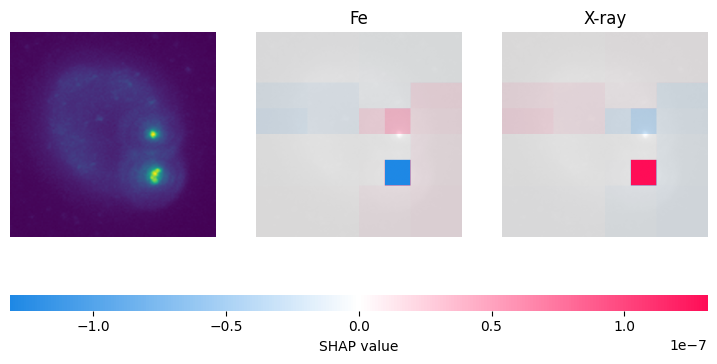

In [ ]:
# SHAP Heatmap for Vision Transformer (Modular)

# GLOBAL CONFIGURATION
MODEL_PATH = "/content/drive/MyDrive/vit_training/vit-checkpoint-final2"
IMAGE_PATHS = [
    "/content/train_unzipped/train/test/Fe/P242_73665006707-A6_001_014_proj.tif",
    # Add more image paths here
]
CLASS_NAMES = ["Fe", "X-ray"]
IMAGE_SIZE = (224, 224)
MASKER_TYPE = "blur(64,64)"  # Options: "blur(64,64)", "inpaint_telea"
MAX_EVALS = 300
BATCH_SIZE = 50
TOP_CLASSES = 2  # How many top classes to visualise per image
COLOURMAP = 'viridis'

# LOAD MODEL AND PROCESSOR
model = ViTForImageClassification.from_pretrained(MODEL_PATH)
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model.eval()

# IMAGE PREPROCESSING
def load_and_preprocess_image(path):
    img = tifffile.imread(path)
    img = (img - img.min()) / (img.max() - img.min() + 1e-6)
    img = (img * 255).astype(np.uint8)
    img_rgb = np.stack([img] * 3, axis=-1)
    img_resized = Image.fromarray(img_rgb).resize(IMAGE_SIZE)
    return np.array(img_resized).astype(np.float32) / 255.0

def preprocess_batch(image_paths):
    return np.stack([load_and_preprocess_image(p) for p in image_paths])


# SHAP MODEL WRAPPER
def vit_predict(images_np):
    images_torch = torch.tensor(images_np).permute(0, 3, 1, 2)
    inputs = processor(images=images_torch, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probs.numpy()


# MAIN PIPELINE
def run_shap_explanation(image_paths=IMAGE_PATHS):
    X = preprocess_batch(image_paths)

    # Create SHAP explainer
    masker = shap.maskers.Image(MASKER_TYPE, X[0].shape)
    explainer = shap.Explainer(vit_predict, masker, output_names=CLASS_NAMES)

    # Get SHAP values
    shap_values = explainer(
        X,
        max_evals=MAX_EVALS,
        batch_size=BATCH_SIZE,
        outputs=shap.Explanation.argsort.flip[:TOP_CLASSES]
    )

    # Replace grayscale input panel with viridis-coloured overlays
    for i in range(len(shap_values)):
        img = tifffile.imread(image_paths[i])
        img_norm = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)
        img_resized = Image.fromarray((img_norm * 255).astype(np.uint8)).resize(IMAGE_SIZE)
        img_float = np.array(img_resized).astype(np.float32) / 255.0
        coloured_rgb = plt.get_cmap(COLOURMAP)(img_float)[:, :, :3]
        shap_values.data[i] = coloured_rgb

    # Display SHAP heatmaps
    shap.image_plot(shap_values)


# RUN IT
run_shap_explanation()
